# 15.3 情感分析：使用卷积神经网络
- **目录**
  - 15.3.1 一维卷积
  - 15.3.2 最大时间池化层
  - 15.3.3 textCNN模型
    - 15.3.3.1 定义模型
    - 15.3.3.2 加载预训练词向量
    - 15.3.3.3 训练和评估模型

- 在第6章中，我们探讨了使用二维卷积神经网络处理二维图像数据的机制，并将其应用于局部特征，如相邻像素。
- 虽然卷积神经网络最初是为计算机视觉设计的，但它也被广泛用于自然语言处理。
- 简单地说，只要将任何文本序列想象成一维图像即可。
- 通过这种方式，一维卷积神经网络可以处理文本中的局部特征，例如$n$元语法。
- 本节将使用textCNN模型来演示如何设计一个表示单个文本的卷积神经网络架构。
- 与图15.2.1中使用带有GloVe预训练的循环神经网络架构进行情感分析相比，图15.3.1中唯一的区别在于架构的选择。
<center><img src='../img/nlp-map-sa-cnn.svg'></center>
<center>图15.3.1 将GloVe放入卷积神经网络架构进行情感分析</center>

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
## (391，64，500)，(391，64，500)，49346
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [23]:
list(iter(train_iter))[0][0].shape,len((iter(train_iter)))

(torch.Size([64, 500]), 391)

In [22]:
len(vocab)

49346

In [25]:
list(iter(train_iter))[0]

[tensor([[15243,     7, 13433,  ...,     0,     0,     0],
         [ 1773,   515,    30,  ...,     0,     0,     0],
         [    8,   392,    51,  ...,     0,     0,     0],
         ...,
         [ 4452,     8, 37348,  ...,   787,     9,     8],
         [    0,   122,     2,  ...,   138,    39, 12231],
         [    8,    13,    58,  ...,     0,     0,     0]]),
 tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
         0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0])]

## 15.3.1 一维卷积

- 在介绍该模型之前，让我们先看看一维卷积是如何工作的。
  - 请记住，这只是基于互相关运算的二维卷积的特例。
<center><img src='../img/conv1d.svg'></center>
<center>图$15.3.2$: ⼀维互相关运算。阴影部分是第⼀个输出元素以及⽤于输出计算的输⼊和核张量元素： $0×1+1×2 = 2$</center><br>
- 如图15.3.2中所示，在一维情况下，卷积窗口在输入张量上从左向右滑动。
- 在滑动期间，卷积窗口中某个位置包含的输入子张量（例如图15.3.2中的$0$和$1$）和核张量（例如，图15.3.2中的$1$和$2$）按元素相乘。
- 这些乘法的总和在输出张量的相应位置给出单个标量值（例如图15.3.2中的$0\times1+1\times2=2$）。
- 下面的`corr1d`函数中实现了一维互相关。
  - 给定输入张量`X`和核张量`K`，它返回输出张量`Y`。


In [14]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

- 可从图15.3.2构造输入张量`X`和核张量`K`来验证上述一维互相关实现的输出。

In [15]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

- 对于任何具有多个通道的一维输入，卷积核需要具有相同数量的输入通道。
- 然后，对于每个通道，对输入的一维张量和卷积核的一维张量执行互相关运算，将所有通道上的结果相加以产生一维输出张量。 
- 图15.3.3演示了具有3个输入通道的一维互相关操作。
<center><img src='../img/conv1d-channel.svg'></center>
<center>图15.3.3: 具有3个输入通道的⼀维互相关运算。阴影部分是第⼀个输出元素以及⽤于输出计算的输入和<br>核张量元素： $2 × (−1) + 3 × (−3) + 1 × 3 + 2 × 4 + 0 × 1 + 1 × 2 = 2$</center>
- 可实现多个输入通道的一维互相关运算，并在图15.3.3中验证结果。


In [16]:
def corr1d_multi_in(X, K):
    # 首先，遍历'X'和'K'的第0维（通道维）。然后，把它们加在一起
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

In [17]:
X.shape,K.shape

(torch.Size([3, 7]), torch.Size([3, 2]))

- 注意，多输入通道的一维互相关等同于单输入通道的二维互相关。
- 举例说明，图15.3.3中的多输入通道一维互相关的等价形式是图15.3.4中的单输入通道二维互相关，其中**卷积核的高度必须与输入张量的高度相同。**
<center><img src='../img/conv1d-2d.svg'></center>
<center>图15.3.4: 具有单个输⼊通道的⼆维互相关操作。阴影部分是第⼀个输出元素以及⽤于输出计算的输⼊和内核
张量元素：$2 × (−1) + 3 × (−3) + 1 × 3 + 2 × 4 + 0 × 1 + 1 × 2 = 2$</center>
- 图15.3.2和 图15.3.3中的输出都只有⼀个通道。
- 与第7.4.2节中描述的具有多个输出通道的二维卷积一样，我们也可以为一维卷积指定多个输出通道。

## 15.3.2 最大时间池化层
- 类似地，我们可以使用池化层从序列表示中提取最大值，作为跨时间步的最重要特征。
- textCNN中使用的**最大时间池化层**的工作原理类似于一维全局池化。
- 对于每个通道在不同时间步存储值的多通道输入，每个通道的输出是该通道的最大值。
- 请注意，最大时间池化允许在不同通道上使用不同数量的时间步。

## 15.3.3 textCNN模型
- 使用一维卷积和最大时间池化，textCNN模型将单个预训练的词元表示作为输入，然后获得并转换用于下游应用的序列表示。
- 对于具有由$d$维向量表示的$n$个词元的单个文本序列，输入张量的宽度、高度和通道数分别为$n$、$1$和$d$。textCNN模型将输入转换为输出，如下所示：
  - （1）定义多个一维卷积核，并分别对输入执行卷积运算。具有不同宽度的卷积核可以捕获不同数目的相邻词元之间的局部特征。
  - （2）在所有输出通道上执行最大时间池化层，然后将所有标量池化输出连结为向量。
  - （3）使用全连接层将连结后的向量转换为输出类别。Dropout可以用来减少过拟合。

<center><img src='../img/textcnn.svg'></center>
<center>图15.3.5: textCNN的模型架构</center>

- 图15.3.5通过一个具体的例子说明了textCNN的模型架构。
  - 输入是具有11个词元的句子，其中每个词元由6维向量表示。
  - 因此，我们有一个宽度为11的6通道输入。
  - (每一列就是一个词元的嵌入向量) 定义两个宽度为2和4的一维卷积核，分别具有4个和5个输出通道。
  - 它们产生4个宽度为$11-2+1=10$的输出通道和5个宽度为$11-4+1=8$的输出通道。
  - 尽管这9个通道的宽度不同，但最大时间池化层给出了一个连结的9维向量，该向量最终被转换为用于二元情感预测的2维输出向量。

### 15.3.3.1 定义模型
- 下面的类中实现textCNN模型。
- 与15.2节的双向循环神经网络模型相比，除了用卷积层代替循环神经网络层外，还使用了两个嵌入层：
  - 一个是可训练权重
  - 另一个是固定权重。

In [18]:
## 
class TextCNN(nn.Module):
    ## 49346, 100, [3,4,5], [100,100,100]
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        ## [49346, 100]
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 这个嵌入层不需要训练
        ## 只需将其weight.requires_grad设为False即可
        ## 49346, 100
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        ## (300,2)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # 最大时间池化层没有参数，因此可以共享此实例
        ## 注释中见到是最大池化层，而代码缺失平均池化层，何意？是写错了吗？
        ## 参数为输出长度，此处为1。当输入有批量大小是，那么输出形状为(批量，通道，1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # 创建多个一维卷积层
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            ## 分别为：输入通道数，输出通道数，核大小：
            ## (200,100,3),(200,100,4),(200,100,5)
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # 沿着向量维度将两个嵌入层连结起来，
        # 每个嵌入层的输出形状都是（批量大小，词元数量，词元向量维度）连结起来
        '''
        在列方向垂直拼接两个嵌入层。
        nn.Embedding的参数说明：
        Input: (*), IntTensor or LongTensor of arbitrary shape 
               containing the indices to extract。
        Output: (*, H), where * is the input shape 
               and H=embedding_dim
        对于Embedding(49346,100)的
        输入input:(64,500),那么
        输出outputs:(64,500,100)
        cat之后的embeddings变成(64,500,200)，即批量，序列长度，嵌入长度(作为通道存在)
        参考：https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding
        '''
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # 根据一维卷积层的输入格式，重新排列张量，以便通道作为第2维
        '''
        重排之后变成：(64,200,500)，这种形状即是卷积层需要的输入格式，即:批量，通道，序列长度。        
        '''
        embeddings = embeddings.permute(0, 2, 1)
        # 每个一维卷积层在最大时间池化层合并后，获得的张量形状是（批量大小，通道数，1）
        # 删除最后一个维度并沿通道维度连结
        '''
        (1) conv(embeddings):
            conv的初始化参数为(200,100,3(或4和5)),即输入通道、输出通道、核大小.
            embeddings为(64,200,500)，即批量、通道、序列长度.
            那么conv的输出ouputs为(批量，输出通道，序列长度)，即(64,100,500).
            参考：https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
                  #torch.nn.Conv1d
        (2) pool(conv(embeddings))，适应性平均池化层的输出长度为1，那么pool函数调用后
            的输出长度为(64,100,1),即批量、通道数、l_out=1
            参考：https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool1d.html
                  #torch.nn.AdaptiveAvgPool1d
        (3) relu函数：激活函数不会使得输入的形不发生变化
        (4) squeeze：挤压最后一维，变成(64,100)，即64行100列
        (5) cat：在第二维上拼接3个核卷积运算的结果，变成(64,300)，即encoding的最终形状。
        
        '''
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        '''
        (1) dropout层不改变输入的形状。
        (2) decoder是一个Linear(300,2)，那么计算的结果是(64,300)*(300,2)=(64,2)
            表明是一个小批量64个文本序列的分类结果（0,1），代表评论文本的pos或neg分类标签。
        '''
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [31]:
## AdaptiveAvgPool1d示例
aap=torch.arange(24).reshape(2,3,4).float()
pool=nn.AdaptiveAvgPool1d(1)
## 结果其实就是各行的平均值
aap,pool(aap)

(tensor([[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.]],
 
         [[12., 13., 14., 15.],
          [16., 17., 18., 19.],
          [20., 21., 22., 23.]]]),
 tensor([[[ 1.5000],
          [ 5.5000],
          [ 9.5000]],
 
         [[13.5000],
          [17.5000],
          [21.5000]]]))

In [36]:
pool1=nn.AvgPool1d(2)
pool1(aap)

tensor([[[ 0.5000,  2.5000],
         [ 4.5000,  6.5000],
         [ 8.5000, 10.5000]],

        [[12.5000, 14.5000],
         [16.5000, 18.5000],
         [20.5000, 22.5000]]])

- 创建一个textCNN实例。
  - 包括3个卷积层，卷积核宽度分别为3、4和5，均有100个输出通道。


In [19]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

### 15.3.3.2 加载预训练词向量

- 与 15.2节相同，此处加载预训练的100维GloVe嵌入作为初始化的词元表示。
- 这些词元表示（嵌入权重）在`embedding`中将被训练，在`constant_embedding`中将被固定。


In [20]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
## 词表的嵌入表示：(vocab_size,100)，本例为(49346,100)
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

In [21]:
embeds.shape

torch.Size([49346, 100])

### 15.3.3.3 训练和评估模型

- 现在可以训练textCNN模型进行情感分析。


loss 0.066, train acc 0.978, test acc 0.875
469.9 examples/sec on [device(type='cuda', index=0)]


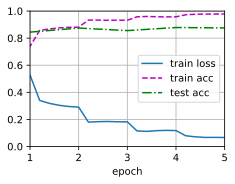

In [9]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

----------------
- **说明：交叉熵损失示例**
  - 参考：https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
  - torch的CrossEntropyLoss类进行交叉熵损失计算

In [46]:
## 交叉熵损失示例
# Example of target with class indices
import torch.nn as nn
import torch
loss = nn.CrossEntropyLoss(reduction='none')
input = torch.randn(64, 2, requires_grad=True)
## 注意random_(2)，这个函数里的参数必须与input的列数对应
## 比如input有2列，那么target的值就只能为0或1。
target = torch.empty(64, dtype=torch.long).random_(2)
output = loss(input, target)
#output.backward()
output

tensor([1.2140, 0.0916, 0.3657, 0.5785, 1.2040, 1.0882, 2.6323, 0.4956, 0.2198,
        0.3820, 0.2255, 0.4384, 0.0236, 0.1283, 0.7404, 0.5891, 0.2951, 0.1661,
        1.4682, 0.5021, 0.7950, 1.8557, 0.0298, 0.7680, 0.2413, 1.0503, 0.6688,
        0.9985, 1.0639, 1.1921, 1.1205, 0.6438, 0.4209, 0.7359, 0.1823, 0.1377,
        0.5085, 1.0356, 0.1918, 0.6429, 0.3013, 0.1155, 0.1065, 0.4333, 0.8892,
        0.1278, 0.3635, 0.5222, 1.8138, 2.4739, 0.0926, 1.0799, 2.2654, 1.3905,
        2.6091, 1.3631, 2.6787, 0.3411, 2.5888, 2.4002, 0.4076, 2.8460, 1.5924,
        0.9701], grad_fn=<NllLossBackward0>)

In [47]:
input.shape,target.shape

(torch.Size([64, 2]), torch.Size([64]))

- 手工计算

  - (1) reduction='none'的情况
 
    <img src='../img/15_3_1.png' width=600px />
 
  - 关键是${x_{n,y_n}}$的获取，在inputs的每行取${y_n}$（本例取值: 0和1）作为列索引的那个元素。

In [75]:
## 通过迭代方式来取x_nyn
torch.set_printoptions(sci_mode=False)
x=input.clone().detach().numpy()
x_nyn=[]
for i in range(x.shape[0]):
    x_nyn.append(x[i,target[i]])
x_nyn=torch.tensor(x_nyn)
x_nyn

tensor([    -0.0007,      1.3650,      1.0777,      0.8536,      0.7914,
             0.1851,     -1.6316,      0.1449,      1.4956,      1.0389,
             0.2958,     -0.1304,      1.9145,      1.2065,     -0.4908,
             0.5489,      1.8172,      2.5753,     -1.2799,     -0.0457,
            -0.1987,     -1.2462,      2.3137,      1.2385,      0.6655,
            -1.7063,      0.8257,     -0.9936,     -0.3852,      0.5575,
             0.0102,      1.3895,      0.3439,     -1.5629,      1.5536,
             0.0946,     -1.1434,      0.5030,      1.5697,     -0.4459,
             0.2564,      0.0244,      2.0010,     -0.9163,     -0.3837,
             0.5673,      1.1738,     -0.5526,     -0.6259,     -0.2478,
             2.1144,     -0.5277,     -0.9342,      0.2907,     -0.8392,
            -0.4959,     -1.4282,      0.8765,      0.0100,     -2.6141,
            -0.5356,     -1.1579,     -0.7181,     -1.1829])

In [76]:
torch.diag(input[:,target]) ##这种方法很特殊，必须要消化一下

tensor([    -0.0007,      1.3650,      1.0777,      0.8536,      0.7914,
             0.1851,     -1.6316,      0.1449,      1.4956,      1.0389,
             0.2958,     -0.1304,      1.9145,      1.2065,     -0.4908,
             0.5489,      1.8172,      2.5753,     -1.2799,     -0.0457,
            -0.1987,     -1.2462,      2.3137,      1.2385,      0.6655,
            -1.7063,      0.8257,     -0.9936,     -0.3852,      0.5575,
             0.0102,      1.3895,      0.3439,     -1.5629,      1.5536,
             0.0946,     -1.1434,      0.5030,      1.5697,     -0.4459,
             0.2564,      0.0244,      2.0010,     -0.9163,     -0.3837,
             0.5673,      1.1738,     -0.5526,     -0.6259,     -0.2478,
             2.1144,     -0.5277,     -0.9342,      0.2907,     -0.8392,
            -0.4959,     -1.4282,      0.8765,      0.0100,     -2.6141,
            -0.5356,     -1.1579,     -0.7181,     -1.1829],
       grad_fn=<DiagBackward0>)

In [79]:
## 通过对角线取x_nyn，结果和上面一样
x_nyn=torch.diag(input[:,target])
-torch.log(torch.exp(x_nyn)/torch.sum(torch.exp(input),dim=1))

tensor([1.2140, 0.0916, 0.3657, 0.5785, 1.2040, 1.0882, 2.6323, 0.4956, 0.2198,
        0.3820, 0.2255, 0.4384, 0.0236, 0.1283, 0.7404, 0.5891, 0.2951, 0.1661,
        1.4682, 0.5021, 0.7950, 1.8557, 0.0298, 0.7680, 0.2413, 1.0503, 0.6688,
        0.9985, 1.0639, 1.1921, 1.1205, 0.6438, 0.4209, 0.7359, 0.1823, 0.1377,
        0.5085, 1.0356, 0.1918, 0.6429, 0.3013, 0.1155, 0.1065, 0.4333, 0.8892,
        0.1278, 0.3635, 0.5222, 1.8138, 2.4739, 0.0926, 1.0799, 2.2654, 1.3905,
        2.6091, 1.3631, 2.6787, 0.3411, 2.5888, 2.4002, 0.4076, 2.8460, 1.5924,
        0.9701], grad_fn=<NegBackward0>)

In [78]:
output

tensor([1.2140, 0.0916, 0.3657, 0.5785, 1.2040, 1.0882, 2.6323, 0.4956, 0.2198,
        0.3820, 0.2255, 0.4384, 0.0236, 0.1283, 0.7404, 0.5891, 0.2951, 0.1661,
        1.4682, 0.5021, 0.7950, 1.8557, 0.0298, 0.7680, 0.2413, 1.0503, 0.6688,
        0.9985, 1.0639, 1.1921, 1.1205, 0.6438, 0.4209, 0.7359, 0.1823, 0.1377,
        0.5085, 1.0356, 0.1918, 0.6429, 0.3013, 0.1155, 0.1065, 0.4333, 0.8892,
        0.1278, 0.3635, 0.5222, 1.8138, 2.4739, 0.0926, 1.0799, 2.2654, 1.3905,
        2.6091, 1.3631, 2.6787, 0.3411, 2.5888, 2.4002, 0.4076, 2.8460, 1.5924,
        0.9701], grad_fn=<NllLossBackward0>)

-----------------
- **说明：d2l包中的train_ch13函数与train_batch_ch13函数的详细注释**

In [26]:
"""train_ch13函数调用本函数进行批量训练"""
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with mutiple GPUs (defined in Chapter 13).
    Defined in :numref:`sec_image_augmentation`"""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    ## X:(64,500)，作为inputs调用TextCNN的forward函数
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

'''本例中调用'''
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with mutiple GPUs (defined in Chapter 13).

    Defined in :numref:`sec_image_augmentation`"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    '''
    在模块级别实现数据并行。
    该容器通过批处理维度中的分块(其他对象将在每个设备上复制一次)跨指定设备分割输入，
    从而并行化给定模块的应用程序。在正向传递中，模块被复制到每个设备上，每个副本处理输入的一部分。
    在向后传递过程中，每个副本的梯度被加到原始模块中。
    批处理大小应该大于所使用的gpu数量。
    一句话：在多块GPU上并行处理数据，加快数据的计算。
    '''
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            ## fetures:(64,500),labels:(500,)
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

----------

- 下面使用训练好的模型来预测两个简单句子的情感。


In [10]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [11]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

In [12]:
d2l.predict_sentiment(net, vocab, 'this movie is  little bad' )

'negative'

## 小结

* 一维卷积神经网络可以处理文本中的局部特征，例如$n$元语法。
* 多输入通道的一维互相关等价于单输入通道的二维互相关。
* 最大时间池化层允许在不同通道上使用不同数量的时间步长。
* textCNN模型使用一维卷积层和最大时间池化层将单个词元表示转换为下游应用输出。